## CENSUS DATA

## Classification / Income Prediction


#### Predicting High-Income Individuals

To identify individuals likely to earn above $50K, we build supervised classification models using demographic, employment, and financial attributes. Multiple models including Logistic Regression, Random Forest, and XGBoost were evaluated to handle class imbalance and capture both linear and non-linear patterns in the data. Model performance was compared using weighted ROC-AUC, precision, recall, and confusion matrix, with special focus on correctly identifying the high-income class. Threshold tuning and class-imbalance handling were applied to optimize real-world decision performance.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix, roc_curve,
    precision_score, recall_score, f1_score, auc, average_precision_score
)

import xgboost
from xgboost import XGBClassifier

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)


#### Data Loading

In [2]:
DATA_DIR = Path("./")  
COL_PATH = DATA_DIR / "census-bureau.columns"
DATA_PATH = DATA_DIR / "census-bureau.data"

In [3]:
##### I want to save all the plots to a folder in the Directory #####


PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

def savefig(name):
    path = os.path.join(PLOTS_DIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    print("Saved:", path)


In [4]:
# Loading column names and data 
with open(COL_PATH) as f:
    cols = [line.strip() for line in f if line.strip()]
print("Columns loaded:", len(cols))
df = pd.read_csv(DATA_PATH, header=None, names=cols)
print("Shape:", df.shape)
print(df.columns.tolist())
df.head()


Columns loaded: 42
Shape: (199523, 42)
['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'weight', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admi

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [5]:
df["target"] = df["label"].astype(str).str.contains(r"50000\+").astype(int)


In [6]:
print("========== SANITY CHECK ==========\n")

# 1. Dataset shape
print("Shape:", df.shape)

# 2. Target distribution
print("\nTarget distribution:")
print(df["target"].value_counts(dropna=False))

# 3. Weighted target distribution (if weight exists)
if "weight" in df.columns:
    w = df.groupby("target")["weight"].sum()
    print("\nWeighted distribution:")
    print(w)
    print("\nWeighted share:")
    print((w / w.sum()).round(3))

# 4. Check label column content
label_col = df.columns[-1]
print("\nLabel column used:", label_col)
print("Unique label values:", df[label_col].unique())

# 5. Check missing values
print("\nTop missing columns:")
print(df.isna().mean().sort_values(ascending=False).head(10))

# 6. Basic numeric sanity
if "age" in df.columns:
    print("\nAge stats:")
    print(df["age"].describe())

if "weeks worked in year" in df.columns:
    print("\nWeeks worked stats:")
    print(df["weeks worked in year"].describe())

# 7. Check that target matches label
print("\nCross-tab (label vs target):")
print(pd.crosstab(df[label_col], df["target"]))

print("\n========== SANITY CHECK DONE ==========")


========== SANITY CHECK ==========

Shape: (199523, 43)

Target distribution:
target
0    187141
1     12382
Name: count, dtype: int64

Weighted distribution:
target
0    3.250046e+08
1    2.224125e+07
Name: weight, dtype: float64

Weighted share:
target
0    0.936
1    0.064
Name: weight, dtype: float64

Label column used: target
Unique label values: [0 1]

Top missing columns:
hispanic origin                       0.00438
detailed household and family stat    0.00000
weight                                0.00000
migration code-change in msa          0.00000
migration code-change in reg          0.00000
migration code-move within reg        0.00000
live in this house 1 year ago         0.00000
migration prev res in sunbelt         0.00000
num persons worked for employer       0.00000
family members under 18               0.00000
dtype: float64

Age stats:
count    199523.000000
mean         34.494199
std          22.310895
min           0.000000
25%          15.000000
50%          33.

#### Data Cleaning

In [7]:
# Replace ? with NaN 
df = df.replace("?", np.nan)

# Target from label values 
df["target"] = df["label"].astype(str).str.contains(r"50000\+").astype(int)

# Sanity check
print(df["target"].value_counts())


target
0    187141
1     12382
Name: count, dtype: int64


In [8]:
missing = df.isna().mean().sort_values(ascending=False)
missing.head(15)


migration code-change in msa                  0.499672
migration code-change in reg                  0.499672
migration code-move within reg                0.499672
migration prev res in sunbelt                 0.499672
country of birth father                       0.033645
country of birth mother                       0.030668
country of birth self                         0.017006
hispanic origin                               0.004380
state of previous residence                   0.003548
citizenship                                   0.000000
own business or self employed                 0.000000
detailed household and family stat            0.000000
fill inc questionnaire for veteran's admin    0.000000
family members under 18                       0.000000
num persons worked for employer               0.000000
dtype: float64

In [9]:
# Drop rows where target missing 
df = df.dropna(subset=["target"])

In [10]:
WEIGHT_COL = "weight"
TARGET_COL = "target"

NUMERIC_COLS = [
    "age",
    "detailed industry recode",
    "detailed occupation recode",
    "wage per hour",
    "capital gains",
    "capital losses",
    "dividends from stocks",
    "num persons worked for employer",
    "own business or self employed",
    "veterans benefits",
    "weeks worked in year",
    "year"
]

CATEGORICAL_COLS = [
    c for c in df.columns
    if c not in NUMERIC_COLS + ["label", TARGET_COL, WEIGHT_COL]
]

print("Numeric:", len(NUMERIC_COLS))
print("Categorical:", len(CATEGORICAL_COLS))


Numeric: 12
Categorical: 28


In [11]:
for col in NUMERIC_COLS:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df[col].fillna(df[col].median())

for col in CATEGORICAL_COLS:
    df[col] = df[col].astype("object").where(df[col].notna(), "Missing")


#### Exploratory Data Analysis

Saved: plots/target_unweighted.png


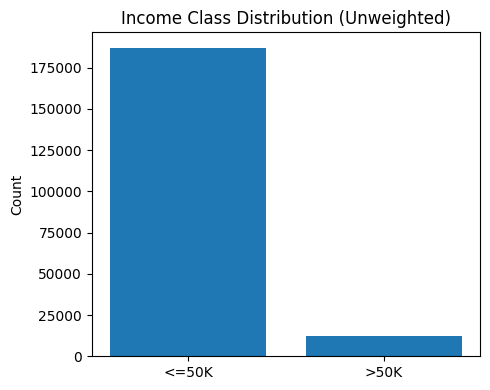

Saved: plots/target_weighted.png


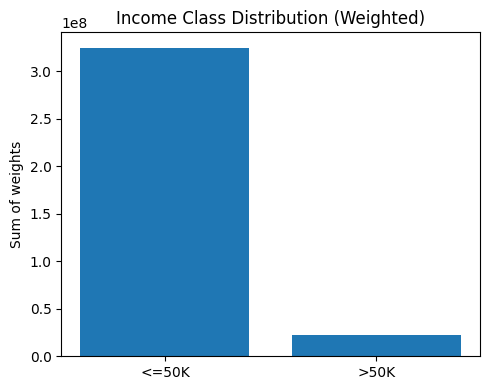

Weighted class share:
 target
0    0.93595
1    0.06405
Name: weight, dtype: float64


In [12]:
# Unweighted
c = df[TARGET_COL].value_counts().sort_index()
plt.figure(figsize=(5,4))
plt.bar(["<=50K", ">50K"], c.values)
plt.title("Income Class Distribution (Unweighted)")
plt.ylabel("Count")
savefig("target_unweighted.png")
plt.show()

# Weighted
cw = df.groupby(TARGET_COL)[WEIGHT_COL].sum().sort_index()
plt.figure(figsize=(5,4))
plt.bar(["<=50K", ">50K"], cw.values)
plt.title("Income Class Distribution (Weighted)")
plt.ylabel("Sum of weights")
savefig("target_weighted.png")
plt.show()

print("Weighted class share:\n", (cw / cw.sum()))


In [13]:
df.groupby("target")["age"].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,187141.0,33.715316,22.620236,0.0,14.0,31.0,49.0,90.0
1,12382.0,46.266193,11.830906,16.0,38.0,45.0,53.0,90.0


In [14]:
df.groupby("target")["weeks worked in year"].describe()


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,187141.0,21.527762,24.118209,0.0,0.0,0.0,52.0,52.0
1,12382.0,48.069617,12.259412,0.0,52.0,52.0,52.0,52.0


In [15]:
df.groupby("target")["capital gains"].describe()


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,187141.0,143.848013,1815.343341,0.0,0.0,0.0,0.0,99999.0
1,12382.0,4830.930060,16887.627002,0.0,0.0,0.0,0.0,99999.0


In [16]:
df.groupby(["target", "education"]).size().unstack().fillna(0)


education,10th grade,11th grade,12th grade no diploma,1st 2nd 3rd or 4th grade,5th or 6th grade,7th and 8th grade,9th grade,Associates degree-academic program,Associates degree-occup /vocational,Bachelors degree(BA AB BS),Children,Doctorate degree(PhD EdD),High school graduate,Less than 1st grade,Masters degree(MA MS MEng MEd MSW MBA),Prof school degree (MD DDS DVM LLB JD),Some college but no degree
target,,,,,,,,,,,,,,,,,
0,7495.0,6806.0,2092.0,1786.0,3255.0,7935.0,6192.0,3951.0,4945.0,15950.0,47422.0,606.0,46528.0,818.0,4503.0,824.0,26033.0
1,62.0,70.0,34.0,13.0,22.0,72.0,38.0,412.0,413.0,3915.0,0.0,657.0,1879.0,1.0,2038.0,969.0,1787.0


Saved: plots/age_by_income.png


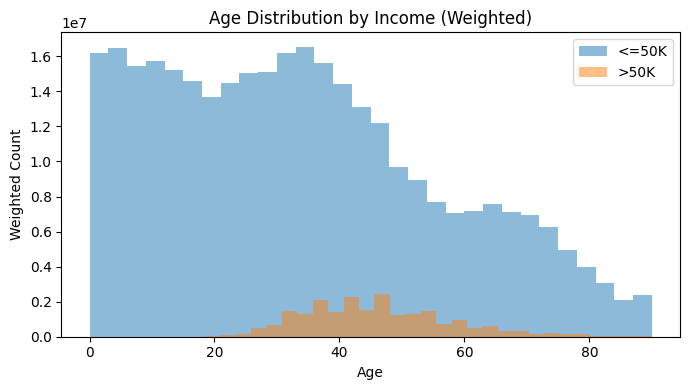

In [17]:
plt.figure(figsize=(7,4))

for t, label in [(0, "<=50K"), (1, ">50K")]:
    sub = df[df[TARGET_COL] == t]
    plt.hist(sub["age"], bins=30, alpha=0.5,
             weights=sub[WEIGHT_COL] if WEIGHT_COL in df.columns else None,
             label=label)

plt.title("Age Distribution by Income (Weighted)")
plt.xlabel("Age")
plt.ylabel("Weighted Count")
plt.legend()
savefig("age_by_income.png")
plt.show()


Saved: plots/education_stacked_weighted_pct.png


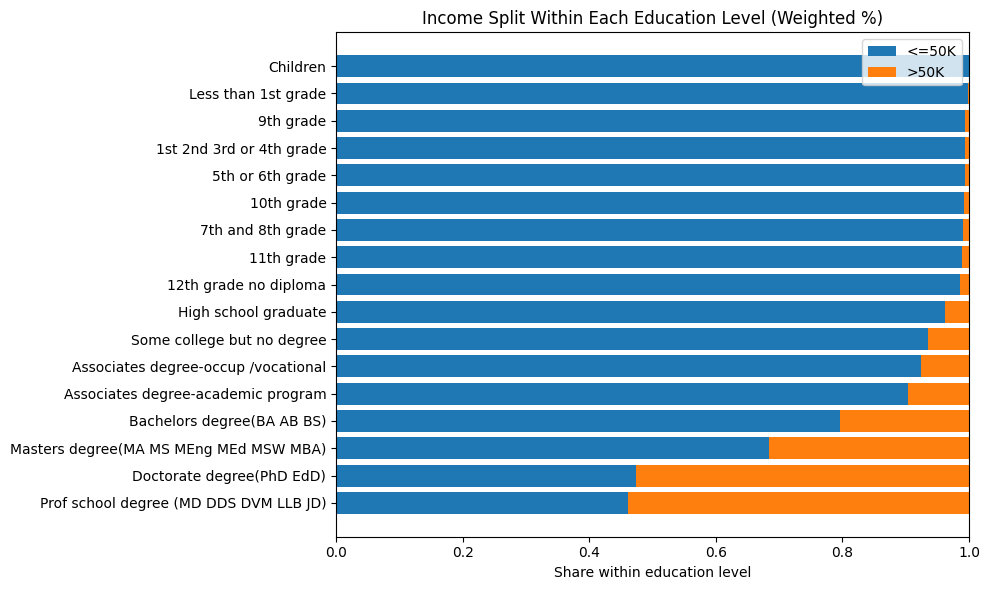

In [18]:
edu = (
    df.groupby(["education", TARGET_COL])[WEIGHT_COL].sum()
      .reset_index()
)

edu_p = edu.pivot(index="education", columns=TARGET_COL, values=WEIGHT_COL).fillna(0)
edu_p.columns = ["<=50K", ">50K"]

edu_pct = edu_p.div(edu_p.sum(axis=1), axis=0).sort_values(">50K", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(edu_pct.index, edu_pct["<=50K"], label="<=50K")
plt.barh(edu_pct.index, edu_pct[">50K"], left=edu_pct["<=50K"], label=">50K")
plt.title("Income Split Within Each Education Level (Weighted %)")
plt.xlabel("Share within education level")
plt.legend()
savefig("education_stacked_weighted_pct.png")
plt.show()


Saved: plots/weeks_by_income.png


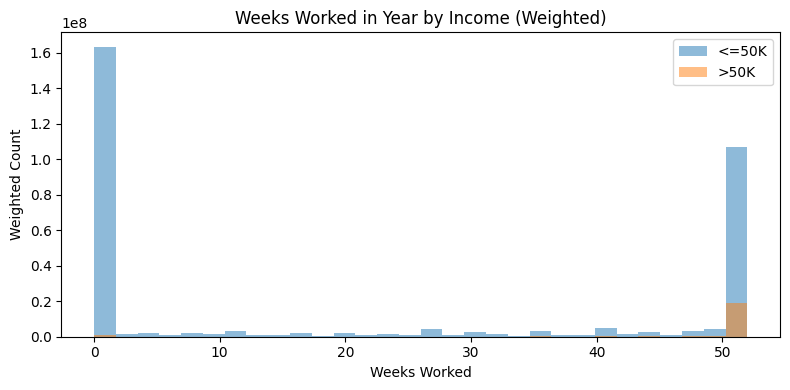

In [19]:
plt.figure(figsize=(8,4))

for t, label in [(0, "<=50K"), (1, ">50K")]:
    sub = df[df[TARGET_COL] == t]
    plt.hist(sub["weeks worked in year"], bins=30, alpha=0.5,
             weights=sub[WEIGHT_COL] if WEIGHT_COL in df.columns else None,
             label=label)

plt.title("Weeks Worked in Year by Income (Weighted)")
plt.xlabel("Weeks Worked")
plt.ylabel("Weighted Count")
plt.legend()
savefig("weeks_by_income.png")
plt.show()


Saved: plots/capital_gains_nonzero_share.png


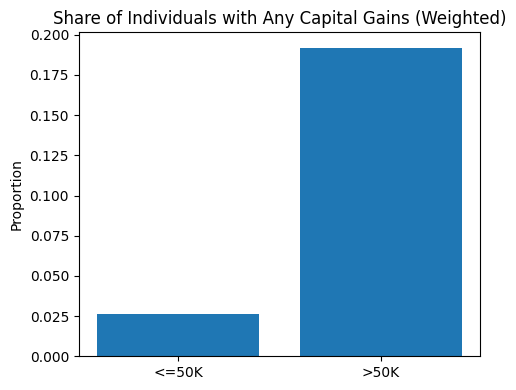

target
0    0.026569
1    0.191945
dtype: float64

target
0    0.026569
1    0.191945
dtype: float64

In [20]:
has_gain = (df["capital gains"] > 0).astype(int)

share = df.groupby(TARGET_COL).apply(
    lambda g: np.average(has_gain[g.index],
                         weights=g[WEIGHT_COL] if WEIGHT_COL in df.columns else None),
    include_groups=False
)

plt.figure(figsize=(5,4))
plt.bar(["<=50K", ">50K"], share.values)
plt.title("Share of Individuals with Any Capital Gains (Weighted)")
plt.ylabel("Proportion")
savefig("capital_gains_nonzero_share.png")
plt.show()

share




Saved: plots/capital_gains_nonzero_dist.png


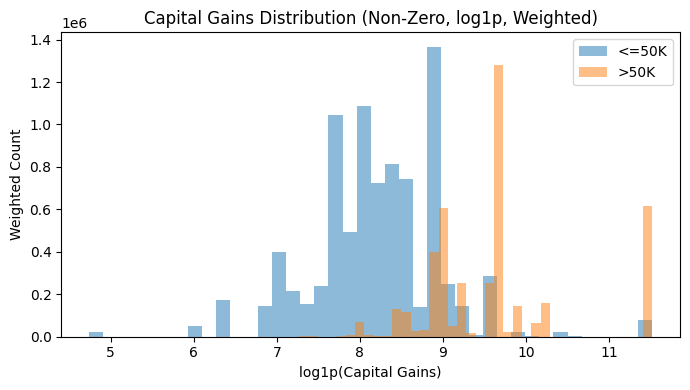

In [21]:
nonzero = df[df["capital gains"] > 0]

plt.figure(figsize=(7,4))

for t, label in [(0, "<=50K"), (1, ">50K")]:
    sub = nonzero[nonzero[TARGET_COL] == t]
    plt.hist(np.log1p(sub["capital gains"]), bins=40, alpha=0.5,
             weights=sub[WEIGHT_COL] if WEIGHT_COL in df.columns else None,
             label=label)

plt.title("Capital Gains Distribution (Non-Zero, log1p, Weighted)")
plt.xlabel("log1p(Capital Gains)")
plt.ylabel("Weighted Count")
plt.legend()
savefig("capital_gains_nonzero_dist.png")
plt.show()


#### Data Split

In [22]:
X = df[NUMERIC_COLS + CATEGORICAL_COLS].copy()
y = df[TARGET_COL].copy()
w = df[WEIGHT_COL].copy()

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape


((159618, 40), (39905, 40))

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMERIC_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_COLS),
    ]
)


#### MODELS (ALL EXPERIMENTS)

In [24]:
#### Defining Model Evaluation Function here ####


def eval_model(name, model, X_test, y_test, w_test, threshold=0.5, y_prob=None):
    if y_prob is None:
        y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    print(f"\n=== {name} (threshold={threshold}) ===")
    print(classification_report(y_test, y_pred))
    print("Weighted ROC-AUC:", roc_auc_score(y_test, y_prob, sample_weight=w_test))
    print("Weighted PR-AUC (avg precision):", average_precision_score(y_test, y_prob, sample_weight=w_test))

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)
    return y_prob, y_pred, cm


In [25]:
###### Experiment 1. Logistic Regression (Baseline) #####

log_model = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train, model__sample_weight=w_train)
log_prob, log_pred, log_cm = eval_model("Logistic Regression", log_model, X_test, y_test, w_test, threshold=0.5)



=== Logistic Regression (threshold=0.5) ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     37429
           1       0.71      0.39      0.50      2476

    accuracy                           0.95     39905
   macro avg       0.84      0.69      0.74     39905
weighted avg       0.95      0.95      0.95     39905

Weighted ROC-AUC: 0.9460259852698777
Weighted PR-AUC (avg precision): 0.6182078417974621
Confusion matrix [[TN FP],[FN TP]]:
 [[37039   390]
 [ 1521   955]]


Logistic Regression was used as a simple baseline model. Although it achieved high overall accuracy (95%), this was mainly due to class imbalance. The model showed good precision for the high-income class but very low recall, meaning it missed many individuals earning more than $50K. This indicates that the linear model struggled to capture the complex patterns in the data and was biased toward the majority class. While useful as a benchmark, it was not suitable as the final model.

In [26]:
###### Experiment 2. Random Forest (Baseline) #####

rf_model = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train, model__sample_weight=w_train)
rf_prob, rf_pred, rf_cm = eval_model("Random Forest", rf_model, X_test, y_test, w_test, threshold=0.5)



=== Random Forest (threshold=0.5) ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     37429
           1       0.75      0.40      0.52      2476

    accuracy                           0.95     39905
   macro avg       0.86      0.69      0.75     39905
weighted avg       0.95      0.95      0.95     39905

Weighted ROC-AUC: 0.9431884030525339
Weighted PR-AUC (avg precision): 0.6421021453272712
Confusion matrix [[TN FP],[FN TP]]:
 [[37108   321]
 [ 1494   982]]


The Random Forest model slightly improved performance over Logistic Regression by capturing nonlinear relationships in the data. While overall accuracy remained high, recall for the high-income class was still low, meaning many high-income individuals were missed. The model showed strong precision but remained biased toward the majority class, limiting its usefulness for minority detection

In [27]:
#### Experiment 3. Random Forest with threshold tuning, threshold = 0.3 #####


_ = eval_model("Random Forest (tuned threshold)", rf_model, X_test, y_test, w_test, threshold=0.30, y_prob=rf_prob)



=== Random Forest (tuned threshold) (threshold=0.3) ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     37429
           1       0.58      0.63      0.60      2476

    accuracy                           0.95     39905
   macro avg       0.78      0.80      0.79     39905
weighted avg       0.95      0.95      0.95     39905

Weighted ROC-AUC: 0.9431884030525339
Weighted PR-AUC (avg precision): 0.6421021453272712
Confusion matrix [[TN FP],[FN TP]]:
 [[36286  1143]
 [  920  1556]]


Lowering the classification threshold increased the model’s sensitivity to the high-income class, improving recall and allowing more high-income individuals to be detected. However, this also increased the number of false positives, reducing precision. This experiment demonstrated the tradeoff between recall and precision and showed that threshold tuning can help control model behavior depending on whether the goal is aggressive detection or balanced prediction

In [28]:
#### Experiment 4. Logistic Regression with class weighting (balanced) #####

log_bal = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

log_bal.fit(X_train, y_train, model__sample_weight=w_train)
logb_prob, logb_pred, logb_cm = eval_model("LogReg class_weight=balanced", log_bal, X_test, y_test, w_test, threshold=0.5)



=== LogReg class_weight=balanced (threshold=0.5) ===
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     37429
           1       0.28      0.90      0.43      2476

    accuracy                           0.85     39905
   macro avg       0.64      0.87      0.67     39905
weighted avg       0.95      0.85      0.89     39905

Weighted ROC-AUC: 0.9456208975645122
Weighted PR-AUC (avg precision): 0.6136252656692576
Confusion matrix [[TN FP],[FN TP]]:
 [[31805  5624]
 [  257  2219]]


Applying class weighting significantly improved recall for the high-income class, allowing the model to detect most high-income individuals. However, this came at the cost of very low precision and a large number of false positives. While this version reduced missed high-income cases, the predictions became noisy and less reliable overall.

In [29]:
#### Experiment 5. Random Forest with class weights (balanced) #####

# compute balanced class weights from training labels
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
class_weights = {0: 1.0, 1: neg / pos}
print("RF class_weights:", class_weights)

rf_bal = Pipeline([
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        class_weight=class_weights
    ))
])

rf_bal.fit(X_train, y_train, model__sample_weight=w_train)
rfb_prob, rfb_pred, rfb_cm = eval_model("RF with class weights", rf_bal, X_test, y_test, w_test, threshold=0.5)


RF class_weights: {0: 1.0, 1: np.float64(15.113264688067838)}

=== RF with class weights (threshold=0.5) ===
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     37429
           1       0.73      0.38      0.50      2476

    accuracy                           0.95     39905
   macro avg       0.85      0.69      0.74     39905
weighted avg       0.95      0.95      0.95     39905

Weighted ROC-AUC: 0.9430905618841446
Weighted PR-AUC (avg precision): 0.6267372592510373
Confusion matrix [[TN FP],[FN TP]]:
 [[37086   343]
 [ 1533   943]]


Adding class weights to the Random Forest model did not produce meaningful improvements. Recall for the high-income class remained low and performance was similar to the unweighted Random Forest. The model continued to favor the majority class despite weighting, indicating limited sensitivity to class imbalance.

In [30]:
#### Experiment 6. XGBoost #####

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos = neg / pos
print("scale_pos_weight:", scale_pos)

xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    min_child_weight=1.0,
    gamma=0.0,
    objective="binary:logistic",
    eval_metric="auc",
    n_jobs=-1,
    random_state=42,
    scale_pos_weight=scale_pos
)

xgb_model = Pipeline([
    ("prep", preprocessor),
    ("model", xgb)
])

xgb_model.fit(X_train, y_train, model__sample_weight=w_train)
xgb_prob, xgb_pred, xgb_cm = eval_model("XGBoost", xgb_model, X_test, y_test, w_test, threshold=0.5)



scale_pos_weight: 15.113264688067838

=== XGBoost (threshold=0.5) ===
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     37429
           1       0.33      0.89      0.48      2476

    accuracy                           0.88     39905
   macro avg       0.66      0.88      0.71     39905
weighted avg       0.95      0.88      0.90     39905

Weighted ROC-AUC: 0.9543147607518644
Weighted PR-AUC (avg precision): 0.6879850750814541
Confusion matrix [[TN FP],[FN TP]]:
 [[32963  4466]
 [  284  2192]]


XGBoost produced the best ranking performance (highest ROC-AUC) and significantly improved detection of high-income individuals. Recall was very high, meaning most high-income cases were captured, but precision was low due to many false positives. This version favored aggressive detection at the cost of prediction quality.

In [31]:
#### XGB threshold check ####

thresholds = np.arange(0.15, 0.56, 0.05)
rows = []

for t in thresholds:
    pred = (xgb_prob >= t).astype(int)
    rows.append({
        "threshold": t,
        "precision_1": precision_score(y_test, pred, zero_division=0),
        "recall_1": recall_score(y_test, pred, zero_division=0),
        "f1_1": f1_score(y_test, pred, zero_division=0)
    })

thr_df = pd.DataFrame(rows).sort_values("f1_1", ascending=False)
thr_df


,threshold,precision_1,recall_1,f1_1
8,0.55,0.354903,0.868336,0.503867
7,0.50,0.329228,0.885299,0.479965
6,0.45,0.305994,0.901050,0.456844
5,0.40,0.286578,0.919225,0.436936
4,0.35,0.266536,0.930937,0.414419
3,0.30,0.247241,0.941034,0.391597
2,0.25,0.228096,0.951535,0.367981
1,0.20,0.207391,0.963247,0.341299
0,0.15,0.184997,0.972132,0.310841


In [32]:
best_t = 0.55
xgb_prob, xgb_pred_t, xgb_cm_t = eval_model("XGBoost (chosen threshold)", xgb_model, X_test, y_test, w_test, threshold=best_t, y_prob=xgb_prob)



=== XGBoost (chosen threshold) (threshold=0.55) ===
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     37429
           1       0.35      0.87      0.50      2476

    accuracy                           0.89     39905
   macro avg       0.67      0.88      0.72     39905
weighted avg       0.95      0.89      0.91     39905

Weighted ROC-AUC: 0.9543147607518644
Weighted PR-AUC (avg precision): 0.6879850750814541
Confusion matrix [[TN FP],[FN TP]]:
 [[33521  3908]
 [  326  2150]]


After tuning the classification threshold, XGBoost achieved a better balance between precision and recall. False positives were reduced while still maintaining strong detection of high-income individuals. This version provided the best overall tradeoff between accuracy, minority detection, and prediction reliability, and was therefore selected as the final model.